In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import random
import os

from tensorflow.keras.layers import Input, Dense, Flatten, GlobalAveragePooling2D, MaxPooling2D
from tensorflow.keras.models import Sequential
from keras.layers import Dropout
from keras.models import Model

C:\Users\ASUS\anaconda3\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [2]:
import zipfile
local_zip = './backup/dataset.zip'
zip_ref = zipfile.ZipFile(local_zip,'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [3]:
Lok = '/tmp/dataset/'

In [4]:
os.listdir('/tmp/dataset/')

['test', 'train']

In [5]:
image_datagen =tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, 
                                                               rotation_range=20,
                                                              width_shift_range=0.2,
                                                              height_shift_range=0.2,
                                                              horizontal_flip=True,
                                                              validation_split=0.2)

In [6]:
train_ds = image_datagen.flow_from_directory(Lok+'/train',
                                            subset='training',
                                            target_size=(150, 150),
                                            batch_size=10)

val_ds   = image_datagen.flow_from_directory(Lok+'/train',
                                            subset='validation',
                                            target_size=(150, 150),
                                            batch_size=10) 

Found 299 images belonging to 2 classes.
Found 74 images belonging to 2 classes.


In [7]:
from tensorflow.keras.applications import VGG16

ModelVGG16 = tf.keras.models.Sequential([
    tf.keras.applications.VGG16(input_shape=(150, 150, 3),
                                         include_top=False,
                                         pooling='max',
                                         weights='imagenet'),
    # tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(256, activation='ReLU'),
    tf.keras.layers.Dense(128, activation='ReLU'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='ReLU'),
    tf.keras.layers.Dense(32, activation='ReLU'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(8, activation='ReLU'),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(2, activation='softmax')
])

In [8]:
ModelVGG16.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.0001,
                                                momentum=0.9
                                                 ), 
            loss='categorical_crossentropy',
            metrics = ['accuracy'])

ModelVGG16.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8

In [9]:
from tensorflow.keras.callbacks import EarlyStopping
CegahUnderOrOver = EarlyStopping(monitor='val_accuracy',
                                patience=10,
                                min_delta=0.001,
                                mode='max',
                                restore_best_weights=True
                                )

In [10]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
reducelr = ReduceLROnPlateau(monitor='val_accuracy',
                            factor=0.3,
                            patience=8,
                            min_lr=0.001,
                            mode='auto',
                            verbose=1)

In [11]:
%%time
train_VGG16 = ModelVGG16.fit(train_ds, validation_data=val_ds, epochs=12, callbacks=[CegahUnderOrOver, reducelr])

Epoch 1/12
30/30 [==============================] - 99s 3s/step - loss: 0.6964 - accuracy: 0.5318 - val_loss: 0.6229 - val_accuracy: 0.5405 - lr: 1.0000e-04
Epoch 2/12
30/30 [==============================] - 77s 3s/step - loss: 0.5945 - accuracy: 0.5853 - val_loss: 0.5258 - val_accuracy: 0.5946 - lr: 1.0000e-04
Epoch 3/12
30/30 [==============================] - 78s 3s/step - loss: 0.5230 - accuracy: 0.6656 - val_loss: 0.4114 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 4/12
30/30 [==============================] - 78s 3s/step - loss: 0.4480 - accuracy: 0.7391 - val_loss: 0.3404 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 5/12
30/30 [==============================] - 81s 3s/step - loss: 0.3330 - accuracy: 0.8528 - val_loss: 0.2253 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 6/12
30/30 [==============================] - 87s 3s/step - loss: 0.2529 - accuracy: 0.9298 - val_loss: 0.1313 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 7/12
30/30 [==============================] - 85s 3s

## Evaluasi Model

8/8 [==============================] - 6s 714ms/step - loss: 7.2402e-04 - accuracy: 1.0000


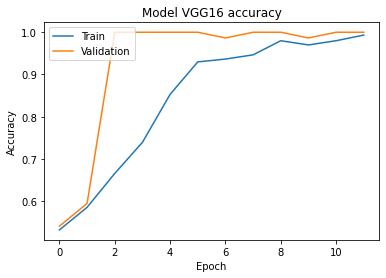

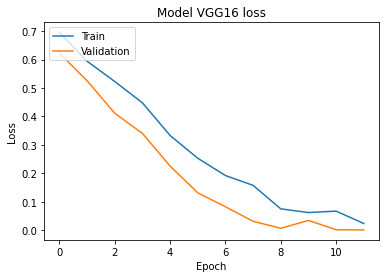

In [12]:
ModelVGG16.evaluate(val_ds)

plt.plot(train_VGG16.history['accuracy'])
plt.plot(train_VGG16.history['val_accuracy'])
plt.title('Model VGG16 accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(train_VGG16.history['loss'])
plt.plot(train_VGG16.history['val_loss'])
plt.title('Model VGG16 loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [13]:
sub_csv ='./backup/Book12.csv'
path_test = './dataset/test/'

In [14]:
df_sub = pd.read_csv(sub_csv)
image_id = df_sub['ID']
df_sub.head(10)

,ID,Label
0,36-0,0
1,20221104_081206,0
2,20221104_081209,0
3,Chicken-Whole-Leg2,0
4,IMG_4911,0
5,IMG_4912,0
6,IMG_4913,0
7,IMG_4914,0
8,IMG_4915,0
9,IMG_4916,0


In [15]:
# Masing-masing gambar akan diperlakukan secara individual dan disimpan dalam daftar yang kemudian bergabung dengan ID file tersebut

from tensorflow.keras.preprocessing.image import load_img


# membuat daftar yg diprediksi
labels = []


for i in image_id:
    image = load_img('./backup/dataset/test/'+str(i)+'.jpg', target_size=(150, 150))
    img = np.array(image)
    img = img / 255.0
    img = img.reshape(1,150,150,3)
    label = ModelVGG16.predict(img)
    label_id = label[0].tolist()
    
    labels.append(label_id.index(max(label_id)))


1/1 [==============================] - 0s 100ms/step


In [16]:
df_sub['Label'] = labels
df_sub.head(10)

,ID,Label
0,36-0,1
1,20221104_081206,0
2,20221104_081209,0
3,Chicken-Whole-Leg2,1
4,IMG_4911,1
5,IMG_4912,1
6,IMG_4913,1
7,IMG_4914,1
8,IMG_4915,1
9,IMG_4916,1


In [17]:
df_prediksi_test = pd.DataFrame({'image_name':image_id,
                                 'prediksi':labels})

In [18]:
df_prediksi_test

,image_name,prediksi
0,36-0,1
1,20221104_081206,0
2,20221104_081209,0
3,Chicken-Whole-Leg2,1
4,IMG_4911,1
5,IMG_4912,1
6,IMG_4913,1
7,IMG_4914,1
8,IMG_4915,1
9,IMG_4916,1


In [19]:
df_prediksi_test.replace(to_replace=[0, 1], value=["AyamSegar", "AyamTiren"], inplace=True)

In [20]:
df_prediksi_test

,image_name,prediksi
0,36-0,AyamTiren
1,20221104_081206,AyamSegar
2,20221104_081209,AyamSegar
3,Chicken-Whole-Leg2,AyamTiren
4,IMG_4911,AyamTiren
5,IMG_4912,AyamTiren
6,IMG_4913,AyamTiren
7,IMG_4914,AyamTiren
8,IMG_4915,AyamTiren
9,IMG_4916,AyamTiren


In [21]:
df_prediksi_test.to_csv("DataPrediksiTest_VGG16.csv", index=False)

In [22]:
ds_aktual = pd.read_csv("./DataTest.csv")
ds_predict = pd.read_csv("./DataPrediksiTest_VGG16.csv")

In [23]:
ds_aktual.rename(columns={'prediksi':'label'}, inplace=True)

In [24]:
ds_aktual

,image_name,label
0,36-0,AyamTiren
1,20221104_081206,AyamSegar
2,20221104_081209,AyamSegar
3,Chicken-Whole-Leg2,AyamSegar
4,IMG_4911,AyamTiren
5,IMG_4912,AyamTiren
6,IMG_4913,AyamTiren
7,IMG_4914,AyamTiren
8,IMG_4915,AyamTiren
9,IMG_4916,AyamTiren


In [25]:
df_test_campur = pd.merge(
    ds_predict,
    ds_aktual,
    how="inner",
    on='image_name')

In [26]:
df_test_campur

,image_name,prediksi,label
0,36-0,AyamTiren,AyamTiren
1,20221104_081206,AyamSegar,AyamSegar
2,20221104_081209,AyamSegar,AyamSegar
3,Chicken-Whole-Leg2,AyamTiren,AyamSegar
4,IMG_4911,AyamTiren,AyamTiren
5,IMG_4912,AyamTiren,AyamTiren
6,IMG_4913,AyamTiren,AyamTiren
7,IMG_4914,AyamTiren,AyamTiren
8,IMG_4915,AyamTiren,AyamTiren
9,IMG_4916,AyamTiren,AyamTiren


## Confusion matrik data test

In [27]:
from sklearn.metrics import confusion_matrix
y_actual = df_test_campur['label']
y_pred = df_test_campur['prediksi']
confusion_matrix(y_actual, y_pred)

array([[ 5,  1],
       [ 0, 13]], dtype=int64)

In [28]:
from sklearn.metrics import classification_report
print(classification_report(y_actual, y_pred))

              precision    recall  f1-score   support

   AyamSegar       1.00      0.83      0.91         6
   AyamTiren       0.93      1.00      0.96        13

    accuracy                           0.95        19
   macro avg       0.96      0.92      0.94        19
weighted avg       0.95      0.95      0.95        19



# Evaluasi data train

In [29]:
sub_csv ='./backup/dataTrain.csv'
path_test = './backup/dataset-real/dataset/train/'

In [30]:
df_sub_train = pd.read_csv(sub_csv)
image_id = df_sub_train['image_name']
df_sub_train.head(10)

,image_name,label
0,20221104_081212,AyamSegar
1,20221104_081215,AyamSegar
2,20221104_081217,AyamSegar
3,20221104_081220,AyamSegar
4,20221104_081222,AyamSegar
5,20221104_081226,AyamSegar
6,20221104_081228,AyamSegar
7,20221104_081233,AyamSegar
8,20221104_081237,AyamSegar
9,20221104_081241,AyamSegar


In [31]:
# Masing-masing gambar akan diperlakukan secara individual dan disimpan dalam daftar yang kemudian bergabung dengan ID file tersebut

from tensorflow.keras.preprocessing.image import load_img


# membuat daftar yg diprediksi
labels = []


for i in image_id:
    image = load_img('./backup/dataset-real/dataset/train/'+str(i)+'.jpg', target_size=(150, 150))
    img = np.array(image)
    img = img / 255.0
    img = img.reshape(1,150,150,3)
    label = ModelVGG16.predict(img)
    label_id = label[0].tolist()
    
    labels.append(label_id.index(max(label_id)))


1/1 [==============================] - 0s 89ms/step


1/1 [==============================] - 0s 107ms/step


1/1 [==============================] - 0s 94ms/step


In [32]:
df_sub_train['Label'] = labels
df_sub_train.head(10)

,image_name,label,Label
0,20221104_081212,AyamSegar,0
1,20221104_081215,AyamSegar,0
2,20221104_081217,AyamSegar,0
3,20221104_081220,AyamSegar,0
4,20221104_081222,AyamSegar,0
5,20221104_081226,AyamSegar,0
6,20221104_081228,AyamSegar,0
7,20221104_081233,AyamSegar,0
8,20221104_081237,AyamSegar,0
9,20221104_081241,AyamSegar,0


In [33]:
df_prediksi_train = pd.DataFrame({'image_name':image_id,
                                 'prediksi':labels})

In [34]:
df_prediksi_train.replace(to_replace=[0, 1], value=["AyamSegar", "AyamTiren"], inplace=True)

In [35]:
df_prediksi_train.to_csv("DataPrediksiTrainValid_VGG16.csv", index=False)

In [36]:
ds_aktual_train = pd.read_csv("./backup/dataTrain.csv")
ds_predict_train = pd.read_csv("./DataPrediksiTrainValid_VGG16.csv")

In [37]:
df_prediksi_train

,image_name,prediksi
0,20221104_081212,AyamSegar
1,20221104_081215,AyamSegar
2,20221104_081217,AyamSegar
3,20221104_081220,AyamSegar
4,20221104_081222,AyamSegar
...,...,...
368,IMG_5121,AyamTiren
369,IMG_5122,AyamTiren
370,IMG_5123,AyamTiren
371,IMG_5124,AyamTiren


In [38]:
df_train_camp = pd.merge(
    ds_aktual_train,
    ds_predict_train,
    how="inner",
    on='image_name')

In [39]:
df_train_camp

,image_name,label,prediksi
0,20221104_081212,AyamSegar,AyamSegar
1,20221104_081215,AyamSegar,AyamSegar
2,20221104_081217,AyamSegar,AyamSegar
3,20221104_081220,AyamSegar,AyamSegar
4,20221104_081222,AyamSegar,AyamSegar
...,...,...,...
368,IMG_5121,AyamTiren,AyamTiren
369,IMG_5122,AyamTiren,AyamTiren
370,IMG_5123,AyamTiren,AyamTiren
371,IMG_5124,AyamTiren,AyamTiren


## Confusion matrik

In [40]:
from sklearn.metrics import confusion_matrix
y_actual = df_train_camp['label']
y_pred = df_train_camp['prediksi']
confusion_matrix(y_actual, y_pred)

array([[173,   0],
       [  0, 200]], dtype=int64)

In [41]:
from sklearn.metrics import classification_report
print(classification_report(y_actual, y_pred))

              precision    recall  f1-score   support

   AyamSegar       1.00      1.00      1.00       173
   AyamTiren       1.00      1.00      1.00       200

    accuracy                           1.00       373
   macro avg       1.00      1.00      1.00       373
weighted avg       1.00      1.00      1.00       373

